In [4]:
!pip install pydicom

In [7]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage as ndimage

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
# Some constants 
INPUT_FOLDER = '/content/drive/My Drive/lungcancer/stage1_train'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(len(patients))
#patients.remove('.DS_Store')

711


In [ ]:
# Load the scans in given folder path
def load_scan(path):
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force = True) for s in ds]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [ ]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

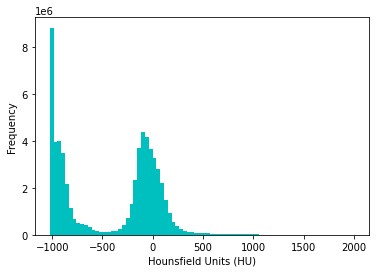

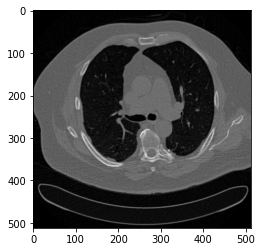

(0.0, 1.0, 0.0, 1.0)

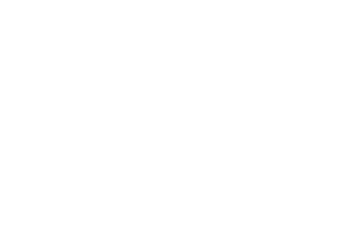

In [ ]:
first_patient = load_scan(INPUT_FOLDER +'/'+ patients[2])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()
plt.axis('off')

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (233, 512, 512)
Shape after resampling	 (350, 414, 414)


In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces,_,_ = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    return plt.show()

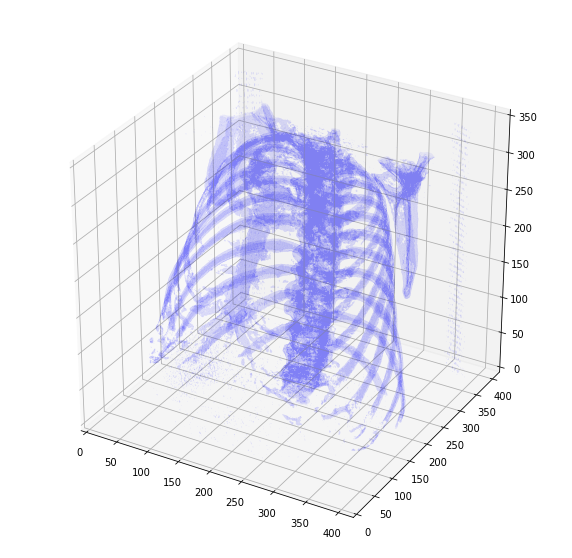

In [ ]:
plot_3d(pix_resampled, 400)

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    biggest = vals[np.argmax(counts)]
    return biggest

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -350, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

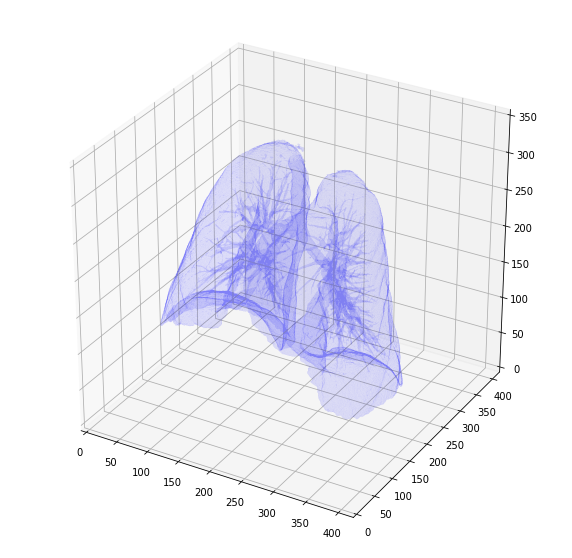

In [ ]:
plot_3d(segmented_lungs, 0)

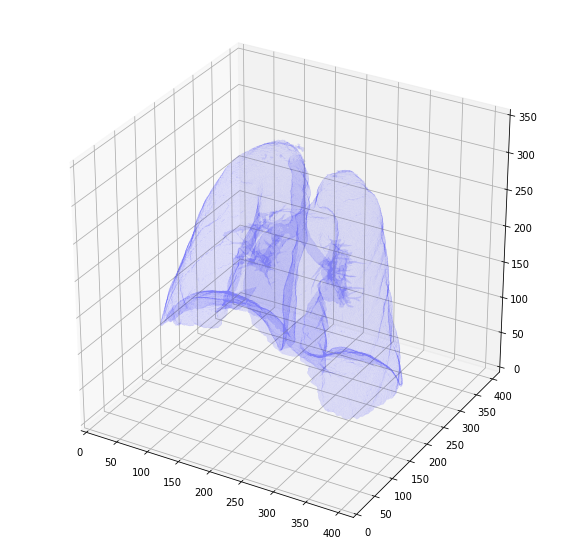

In [ ]:
plot_3d(segmented_lungs_fill, 0)

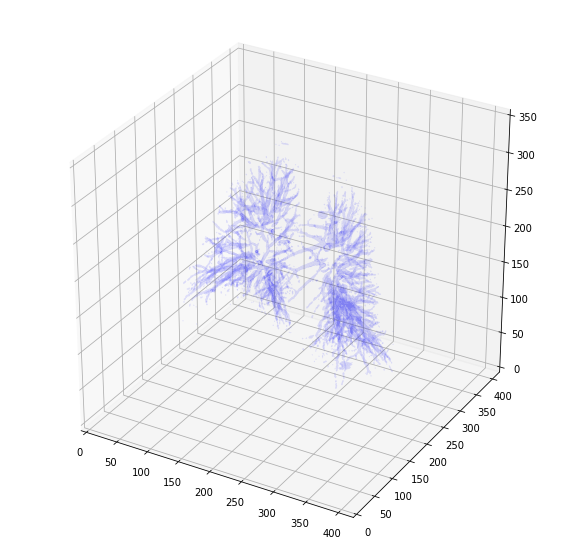

In [ ]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

# Watershed algorithem


In [ ]:
test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[1])
test_patient_images = get_pixels_hu(test_patient_scans)

Original Slice


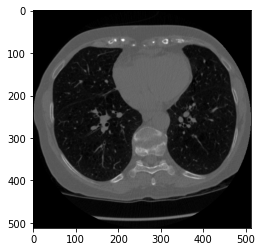

In [ ]:
print ("Original Slice")
plt.imshow(test_patient_images[100], cmap='gray')
plt.show()

Internal Marker


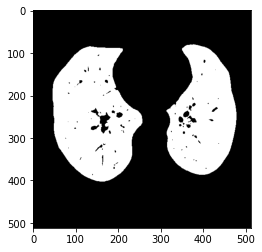

External Marker


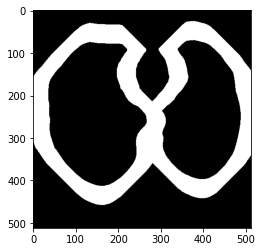

Watershed Marker


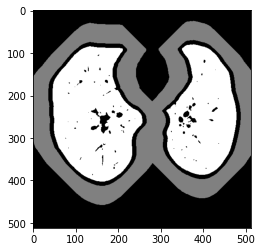

In [ ]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[100])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

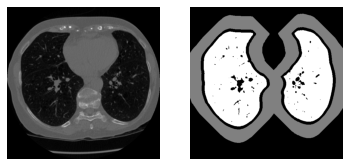

In [ ]:
plt.subplot(121)
plt.imshow(test_patient_images[100],cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_patient_watershed,cmap = 'gray')
plt.axis('off')

Lung Nodule


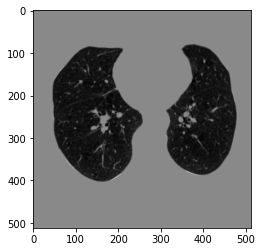

Sobel Gradient


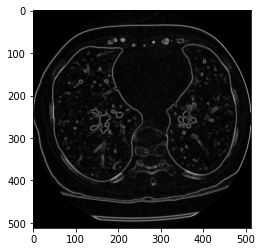

Watershed Image


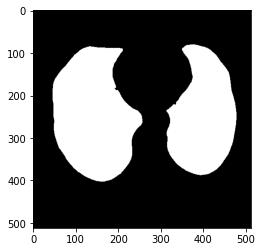

Outline after reinclusion


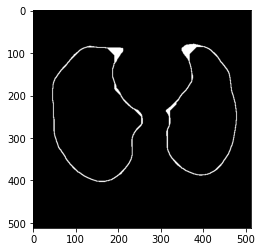

Lungfilter after closing


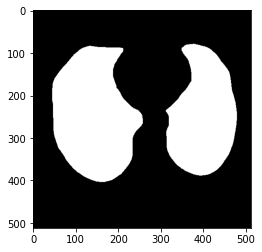

Segmented Lung


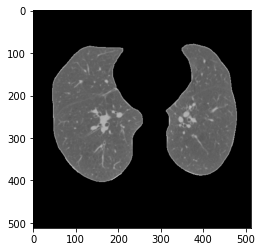

In [ ]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))

    #### nodule
    lung_nodule_1 = np.bitwise_or(marker_internal, image)
    lung_nodule = np.where(lungfilter == 1, lung_nodule_1, np.zeros((512, 512)))

    
    return segmented, lung_nodule, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, lung_nodule, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[100])

print ("Lung Nodule")
plt.imshow(lung_nodule, cmap='gray')
plt.show()
print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

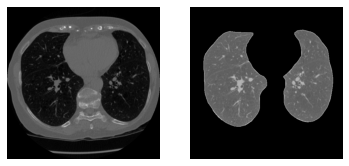

In [ ]:
plt.subplot(121)
plt.imshow(test_patient_images[100],cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_segmented,cmap = 'gray')
plt.axis('off')

In [ ]:
test_segmented.shape

(512, 512)

# Preparation for classifier


In [ ]:
labels_df = pd.read_csv('/content/drive/My Drive/lungcancer/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [ ]:
for patient in patients[:1]:
    label = labels_df.at[(patient, 'cancer')]
    path = INPUT_FOLDER +'/'+ patient
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force=True) for s in ds]
    #slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])
    print(slices[0].PatientID)
    print('len of ds is ',len(ds))
    print(labels_df.at[(str(slices[0].PatientID), 'cancer')])


221 1
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.604252062086956196687067904502
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.604252062086956196687067904502
(0008, 0060) Modality                            CS: 

In [ ]:
data = []
labels = []
print('*'*30)
print("data in converting.......")
print('*'*30)
j = 1
for patient in patients:
    test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[j])
    test_patient_images = get_pixels_hu(test_patient_scans)
    path = INPUT_FOLDER +'/'+ patient
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dicom.read_file((path + '/' + s),force=True) for s in ds]
    print("patient_number_{}".format(j))
    i = 0
    for s in slices:
        try:
          i += 1
          if i in range(0,50):
            continue
          #taking 100 slices from each patient
          elif i in range(50, 150):
            img = test_patient_images[i]
            seg_img = seperate_lungs(img)[0]
            new_img = np.expand_dims(seg_img,axis = -1)
            label = labels_df.at[(str(s.PatientID), 'cancer')]
            data.append(new_img)
            labels.append(label)
        
            print("converted image is : "+str(len(labels)))
          else:
            break
        except IndexError:
          continue
    j += 1
        

print("Done")

******************************
data in converting.......
******************************
patient_number_1
converted image is : 1
converted image is : 2
converted image is : 3
converted image is : 4
converted image is : 5
converted image is : 6
converted image is : 7
converted image is : 8
converted image is : 9
converted image is : 10
converted image is : 11
converted image is : 12
converted image is : 13
converted image is : 14
converted image is : 15
converted image is : 16
converted image is : 17
converted image is : 18
converted image is : 19
converted image is : 20
converted image is : 21
converted image is : 22
converted image is : 23
converted image is : 24
converted image is : 25
converted image is : 26
converted image is : 27
converted image is : 28
converted image is : 29
converted image is : 30
converted image is : 31
converted image is : 32
converted image is : 33
converted image is : 34
converted image is : 35
converted image is : 36
converted image is : 37
converted image 

KeyboardInterrupt: ignored

In [ ]:
print(len(data))
#print(len(ids))# both lists, with columns specified 
print(len(labels))

1002
1002


In [ ]:
data_new = np.array(data)
data_new.shape

(1002, 512, 512, 1)

In [ ]:
labels_new = np.array(labels)
labels_new.shape

(1002,)

In [ ]:
from numpy import save
print("saving data")
save("/content/drive/My Drive/lungcancer/data_4.npy",data_new)
print("saving labels")
save("/content/drive/My Drive/lungcancer/labels_4.npy",labels_new)

saving data
saving labels


In [ ]:
from numpy import load
print("loading data")
data = load("/content/drive/My Drive/lungcancer/data_4.npy")
print("loading labels")
labels = load("/content/drive/My Drive/lungcancer/labels_4.npy")

loading data
loading labels


In [ ]:
print(data.shape)
print(labels.shape)

(1002, 512, 512, 1)
(1002,)


In [ ]:
data_preview = data[:, :, :, 0]

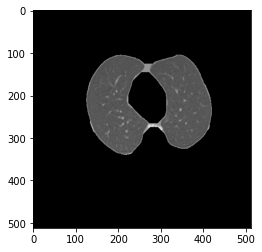

In [ ]:
plt.imshow(data_preview[100],cmap = 'gray')

In [ ]:
labels[100]

0

# Training Models

In [ ]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.1, stratify=labels, random_state=42,shuffle = True)

In [ ]:
trainX.shape

(901, 512, 512, 1)

In [ ]:
trainY.shape

(901,)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
aug_train = ImageDataGenerator(rescale= 1.0/255.,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

aug_test  = ImageDataGenerator(rescale= 1.0/255.)

Using TensorFlow backend.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (512, 512, 1), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(Dropout(0.5))

# Adding Convolution
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))


In [ ]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 253, 253, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 32)     

In [ ]:
import keras as k

In [ ]:
import time
NAME = "test_1-{}".format(int(time.time()))

In [ ]:
callbacks = [
#    k.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    k.callbacks.ModelCheckpoint('test_model_1.h5', save_best_only=True)]

In [ ]:
hist_1 = classifier.fit(aug_train.flow(trainX, trainY, batch_size=32), steps_per_epoch=100, epochs = 50, verbose = 1,
                        validation_data = (testX, testY), callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 80s 798ms/step - loss: 1.2848 - accuracy: 0.6948 - val_loss: 4.7355 - val_accuracy: 0.7129
Epoch 2/50
100/100 [==============================] - 73s 729ms/step - loss: 0.5668 - accuracy: 0.7160 - val_loss: 266.1623 - val_accuracy: 0.7030
Epoch 3/50
100/100 [==============================] - 74s 740ms/step - loss: 0.5498 - accuracy: 0.7114 - val_loss: 81.5317 - val_accuracy: 0.7129
Epoch 4/50
100/100 [==============================] - 74s 737ms/step - loss: 0.5063 - accuracy: 0.7185 - val_loss: 302.0386 - val_accuracy: 0.7129
Epoch 5/50
100/100 [==============================] - 73s 733ms/step - loss: 0.4821 - accuracy: 0.7115 - val_loss: 308.3203 - val_accuracy: 0.7129
Epoch 6/50
100/100 [==============================] - 73s 732ms/step - loss: 0.4644 - accuracy: 0.7204 - val_loss: 611.7558 - val_accuracy: 0.7129
Epoch 7/50
100/100 [==============================] - 72s 721ms/step - loss: 0.4573 - accuracy: 0.7235 - val_loss: 366.17

In [ ]:
aug_train.fit(trainX)

In [ ]:
classifier_2 = Sequential()

# Step 1 - Convolution
classifier_2.add(Conv2D(32, (3, 3), input_shape = (512, 512, 1), activation = 'relu'))

# Step 2 - Pooling
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier_2.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
classifier_2.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a forth convolutional layer
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a forth convolutional layer
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a forth convolutional layer
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier_2.add(Flatten())

# Step 4 - Full connection
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 1, activation = 'sigmoid'))


In [ ]:
classifier_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 253, 253, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)       

In [ ]:
import keras as k

In [ ]:
import time
NAME = "test_2-{}".format(int(time.time()))

In [ ]:
callbacks_2 = [
#    k.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    k.callbacks.ModelCheckpoint('test_model_2.h5', save_best_only=True)]

In [ ]:
hist_2 = classifier_2.fit(aug_train.flow(trainX, trainY, batch_size=32), steps_per_epoch=100, epochs = 50, verbose = 1,
                        validation_data = (testX, testY), callbacks=callbacks_2)

Epoch 1/50
100/100 [==============================] - 69s 686ms/step - loss: 0.5896 - accuracy: 0.7108 - val_loss: 14.1623 - val_accuracy: 0.7129
Epoch 2/50
100/100 [==============================] - 67s 666ms/step - loss: 0.5799 - accuracy: 0.7076 - val_loss: 5.4886 - val_accuracy: 0.7426
Epoch 3/50
100/100 [==============================] - 67s 672ms/step - loss: 0.5252 - accuracy: 0.7150 - val_loss: 68.6541 - val_accuracy: 0.7327
Epoch 4/50
100/100 [==============================] - 67s 666ms/step - loss: 0.4878 - accuracy: 0.7177 - val_loss: 95.8704 - val_accuracy: 0.7129
Epoch 5/50
100/100 [==============================] - 67s 666ms/step - loss: 0.4621 - accuracy: 0.7296 - val_loss: 177.9535 - val_accuracy: 0.7030
Epoch 6/50
100/100 [==============================] - 68s 680ms/step - loss: 0.4440 - accuracy: 0.7645 - val_loss: 146.3362 - val_accuracy: 0.7426
Epoch 7/50
100/100 [==============================] - 67s 670ms/step - loss: 0.4150 - accuracy: 0.7862 - val_loss: 215.4243

Plotting Graph for model - 1

Text(0.5, 0, 'Epoch')

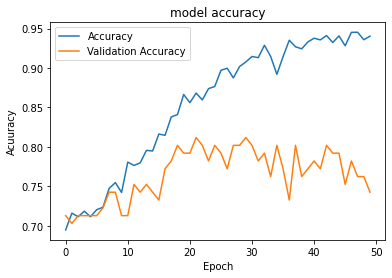

In [ ]:
# print accuracy graph
plt.plot(hist_1.history["accuracy"])
plt.plot(hist_1.history['val_accuracy'])
plt.title("model accuracy")
plt.legend(["Accuracy","Validation Accuracy"])
plt.ylabel("Acuuracy")
plt.xlabel("Epoch")

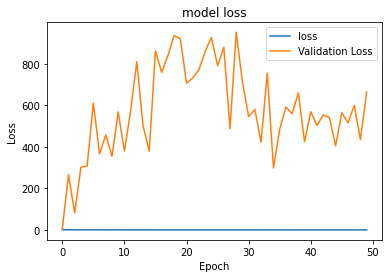

In [ ]:
# print loss graph
import matplotlib.pyplot as plt
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])

Plotting graph for model - 2

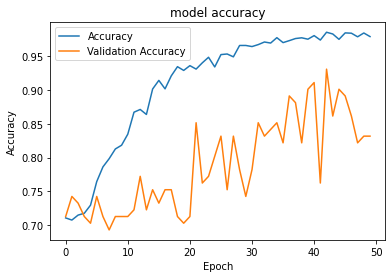

In [ ]:
# print accuracy graph
import matplotlib.pyplot as plt
plt.plot(hist_2.history["accuracy"])
plt.plot(hist_2.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])

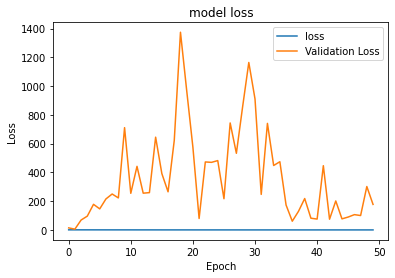

In [ ]:
# print loss graph
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])

# VGG-16 TRANSFER LEARNING 

In [ ]:
import os
import random
import tensorflow as tf
import time
import numpy as np
from tqdm import tqdm
from vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from imagenet_utils import preprocess_input, decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge,Input
from sklearn.utils import shuffle
from keras.models import Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array


In [ ]:
data.shape

(250, 512, 512, 3)

In [ ]:
from skimage.transform import  resize
import numpy as np
data_new = np.zeros((len(data),224,224,3))
for i in range(len(data)):
  image = data[i]
  image_resize =  resize(image, (224, 224), anti_aliasing=True)
  data_new[i] = image_resize
data_new.shape

(250, 224, 224, 3)

In [ ]:
from numpy import save
print("saving data")
save("/content/drive/My Drive/lungcancer/data_channel_3_resized.npy",data_new)

saving data


In [ ]:
from numpy import load
print("loading data")
data = load("/content/drive/My Drive/lungcancer/data_channel_3_resized.npy")
print("loading labels")
labels = load("/content/drive/My Drive/lungcancer/labels_channel_3_3.npy")

loading data
loading labels


In [ ]:
# here data_chanel_3 is a connverted 3 channel images by
# skimages in which
# --> _1 have 501 images with corresponding labesls_channel_3_1
# --> _2 have 501 images with corresponding labesls_channel_3_2
# --> _3 have 250 images with corresponding labesls_channel_3_3
# --> _resized have 250 images which are resized with corresponding labesls_channel_3_3

In [ ]:
data.shape

(250, 224, 224, 3)

In [ ]:
labels.shape

(250,)

In [ ]:
j = 0
for i in labes:
  if i == 1:
    j = j+1
print(j)

In [ ]:
print("there are {} cancer patients in this dataset".format(j))

there are 100 cancer patients in this dataset


In [ ]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.1, stratify=labels, random_state=42,shuffle = True)

In [ ]:
trainX.shape

(225, 224, 224, 3)

In [ ]:
trainY.shape

(225,)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
aug_train = ImageDataGenerator(rescale= 1.0/255.,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

aug_test  = ImageDataGenerator(rescale= 1.0/255.)

In [ ]:
aug_train.fit(trainX)

In [ ]:
NAME = "test_5-{}".format(int(time.time()))

In [ ]:
image_input = Input(shape=(224,224,3))

model = VGG16(input_tensor=image_input, include_top = True, weights = 'imagenet')

model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
last_layer = model.get_layer('fc2').output
x = Dense(128, activation='relu', name='fc3')(last_layer)
x = Dense(128, activation='relu', name='fc4')(x)
out = Dense(1, activation = 'sigmoid', name = 'output')(x)
custom_vgg_model = Model(image_input, out)

In [ ]:
for layer in custom_vgg_model.layers[:-4]:
    layer.trainable = False

custom_vgg_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

custom_vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
callbacks_5 = []
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    #tf.keras.callbacks.ModelCheckpoint('test_model_5.h5', save_best_only=True)]

In [ ]:
hist_5 = custom_vgg_model.fit(aug_train.flow(trainX, trainY, batch_size=32), steps_per_epoch=500, epochs = 50, verbose = 1,
                        validation_data = (testX, testY), callbacks=callbacks_5)

Epoch 1/50
500/500 [==============================] - 185s 370ms/step - loss: 0.3219 - accuracy: 0.9196 - val_loss: 66.4279 - val_accuracy: 0.6400
Epoch 2/50
500/500 [==============================] - 173s 345ms/step - loss: 0.0535 - accuracy: 0.9802 - val_loss: 69.5844 - val_accuracy: 0.7200
Epoch 3/50
500/500 [==============================] - 172s 344ms/step - loss: 0.0265 - accuracy: 0.9899 - val_loss: 43.2154 - val_accuracy: 0.8400
Epoch 4/50
500/500 [==============================] - 174s 348ms/step - loss: 0.1005 - accuracy: 0.9790 - val_loss: 86.6004 - val_accuracy: 0.5600
Epoch 5/50
500/500 [==============================] - 175s 350ms/step - loss: 0.0701 - accuracy: 0.9806 - val_loss: 55.4538 - val_accuracy: 0.7600
Epoch 6/50
500/500 [==============================] - 172s 345ms/step - loss: 0.0724 - accuracy: 0.9803 - val_loss: 77.4031 - val_accuracy: 0.6400
Epoch 7/50
500/500 [==============================] - 171s 341ms/step - loss: 0.0581 - accuracy: 0.9851 - val_loss: 30

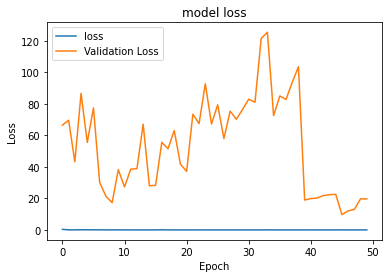

In [ ]:
# print loss graph
import matplotlib.pyplot as plt
plt.plot(hist_5.history['loss'])
plt.plot(hist_5.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])

Text(0.5, 0, 'Epoch')

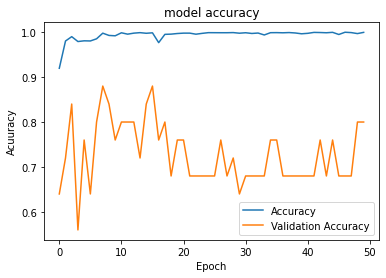

In [ ]:
# print accuracy graph
plt.plot(hist_5.history["accuracy"])
plt.plot(hist_5.history['val_accuracy'])
plt.title("model accuracy")
plt.legend(["Accuracy","Validation Accuracy"])
plt.ylabel("Acuuracy")
plt.xlabel("Epoch")

# ploting some images in different ways

In [ ]:
data_preview.shape

(1002, 512, 512)

In [ ]:
test_image = data_preview[50]

In [ ]:
test_image.shape

(512, 512)

In [ ]:
test_image.dtype

dtype('float64')

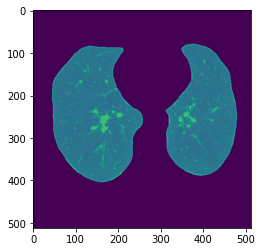

In [ ]:
plt.imshow(test_image)

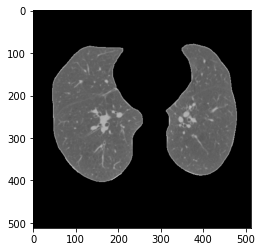

In [ ]:
plt.imshow(test_image, cmap = 'gray')

In [ ]:
import skimage
image = skimage.color.gray2rgb(test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


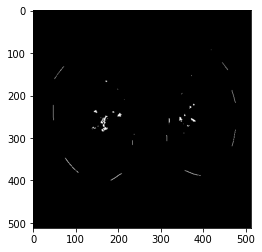

In [ ]:
plt.imshow(image)

In [ ]:
image.shape

(512, 512, 3)

In [ ]:
import cv2
import numpy as np
img = np.array(test_image, dtype=np.uint8)
color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

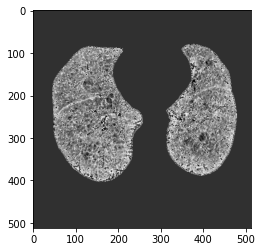

In [ ]:
plt.imshow(color_img)

In [ ]:
color_img.shape

(512, 512, 3)

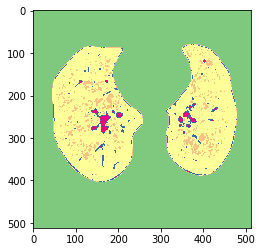

In [ ]:
plt.imshow(data_preview[50], cmap='Accent')

In [ ]:
labels[50]

1

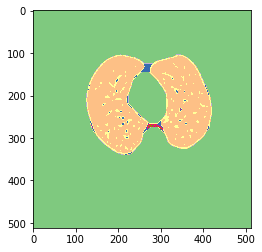

In [ ]:
plt.imshow(data_preview[100], cmap='Accent')

In [ ]:
labels[100]

0